# Importing  all important libraries

In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import _pickle as c
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
import xgboost as xgb
import pickle
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


# Function for reading the file
#### Reads the file in chunks as dataset is large

In [2]:
def reads(filename):
    start = time.time()
    chunk = pd.read_csv(filename, chunksize=1000000)
    end = time.time()
    print("Read csv with chunks: ", (end - start), "sec")
    pd_df = pd.concat(chunk)
    return pd_df


#### This function is used to save the model

In [3]:
def save(clf, name):
# Saves the model at the end
 with open(name, 'wb') as fp:
   c.dump(clf, fp)
 print("saved")

##### This function is used to load the model

In [4]:
def load(file_name):
# Used for reading the data from the file having the data 
 data_list = []
 with open(file_name, 'rb') as f:
    clf = c.load(f)
 return clf

#### This function is used to get the data and preprocess it and return the data in form of training and testing

In [5]:
def getTrainingAndTestingDataset():
    df=reads("C:/Users/Hp/PycharmProjects/pythonProject/AllDataCrop.csv")
    df=df.dropna()
    
    #timestamp and flow id should not be used should not be used as it will be different for every attack.
    df.drop(columns=['Flow ID'], inplace=True)
    df.drop(columns=['Timestamp'], inplace=True)
    df.drop(columns=['Source IP'], inplace=True)
    df.drop(columns=['Source Port'], inplace=True)
    df.drop(columns=['Destination IP'], inplace=True)
    df.drop(columns=['Destination Port'], inplace=True)
    #SimillarHTTP is a object type so has to be converted to string
    df['SimillarHTTP'] = df['SimillarHTTP'].astype('|S')
    
    #Label Encoders for converting the string data  to integer values
    encoder1=preprocessing.LabelEncoder()
    df['SimillarHTTP']=encoder1.fit_transform(df['SimillarHTTP'])
    df['Label']=encoder1.fit_transform(df['Label'])
    
    #the Flow Bytes/s contains large numbers so normalizing it and also has infinity values 
    df['Flow Bytes/s']=df['Flow Bytes/s']/1000000
    mm = df.loc[df['Flow Bytes/s'] != np.inf, 'Flow Bytes/s'].max()
    mm=mm+200
    
    #replacing infinity values with number larger than maximum value so that its credibility doesnt go down
    df['Flow Bytes/s'].replace(np.inf,mm,inplace=True) 
    
    #the Flow Packets/s contains large numbers so normalizing it and also has infinity values 
    df['Flow Packets/s']=df['Flow Packets/s']/1000000
    m = df.loc[df['Flow Packets/s'] != np.inf, 'Flow Packets/s'].max()
    m=m+200
    
    #replacing infinity values with number larger than maximum value so that its credibility doesnt go down
    df['Flow Packets/s'].replace(np.inf,m,inplace=True)
    
    print(df['Flow Packets/s'].value_counts())
    #Dividing the dataset to independent and dependent variables
    X=df.loc[:, df.columns != 'Label']
    print(X['Flow Packets/s'].value_counts())
    Y=df.iloc[:,-1]
    
    #Dividing Data for training and testing 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1) # 70% training and 30% test
    print(X_train['Flow Packets/s'].value_counts())
    #returning the training and testing data
    return (X_train, X_test, Y_train, Y_test)
    

### Function for creating and saving Decision Tree Classifier With Entropy Model 

In [6]:
def decisiontree_entropy(X_train,Y_train): 
    from sklearn import tree
    clf=tree.DecisionTreeClassifier(criterion='entropy')
    clf.fit(X_train,Y_train)
    save(clf, "C:/Users/Hp/PycharmProjects/pythonProject/decisiontree_entropy.mdl")
    return True  


### Function for creating and saving Decision Tree Classifier With GINI INDEX Model 

In [7]:
def decisiontree_gini(X_train,Y_train): 
    from sklearn import tree
    clf=tree.DecisionTreeClassifier()
    clf.fit(X_train,Y_train)
    save(clf, "C:/Users/Hp/PycharmProjects/pythonProject/decisiontree_gini.mdl")
    return True

### Function for creating and saving Random Forest Classifier With Entropy Model

In [8]:
def random_forest_entropy(X_train,Y_train): 
    model = RandomForestClassifier(n_estimators=100, criterion="entropy")#max_depth=15
    model.fit(X_train, Y_train)
    save(model, "C:/Users/Hp/PycharmProjects/pythonProject/random-forest-entropy.mdl")
    return True
    

### Function for creating and saving Random Forest Classifier With GINI INDEX Model

In [9]:
def random_forest_gini(X_train,Y_train): 
    model = RandomForestClassifier(n_estimators=100, criterion="gini")#max_depth=15
    model.fit(X_train, Y_train)
    save(model, "C:/Users/Hp/PycharmProjects/pythonProject/random-forest-gini.mdl")
    return True

### Function for creating and saving Naive Bayes Model

In [10]:
def Naive_Bayes(X_train,Y_train): 
    model = GaussianNB()
    model.fit(X_train,Y_train)
    save(model, "C:/Users/Hp/PycharmProjects/pythonProject/Naive_Bayes.mdl")
    return True

### Function for creating and saving K Nearest Neighbor Classifier Model

In [11]:
def KNearestNeighbor(X_train,Y_train,neighbor,name):
    model = KNeighborsClassifier(n_neighbors=neighbor)
    model.fit(X_train,Y_train)
    save(model, name)
    return True    

### Function for creating and saving Gradient Boost Classifier Model

In [12]:
def GradientBoost(X_train,Y_train,lr,name):
    model = xgb.XGBClassifier(learning_rate=lr)
    model.fit(X_train,Y_train)
    save(model, name)
    return True   

### Function for finding all the creteria of a classifier

In [161]:
def creteria(y_test,y_pred):
    score = f1_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred,  average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    accuracy=metrics.accuracy_score(y_test,y_pred)
    confusion_metrics=metrics.confusion_matrix(y_test,y_pred)
    return {"Accuracy":accuracy,"Precision":precision,"Recall":recall,"F1 score":score,"Confusion Metrics":confusion_metrics}

# Defining all the columns of the dataset

In [14]:
columns= ['Protocol','Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
         'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
         'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
         'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
         'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total',
         'Bwd IAT Mean', ' Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
         'Fwd URG Flags',
         'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
         'Min Packet Length',
         'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
         'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count',
         'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
         'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
         'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
         'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd',
         'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std',
         'Idle Max', 'Idle Min', 'SimillarHTTP', 'Inbound']

## Preprocessing and taking the information of the dataset 

In [13]:
df=reads("C:/Users/Hp/PycharmProjects/pythonProject/AllDataCrop.csv")
df.shape

Read csv with chunks:  0.010999441146850586 sec


<ipython-input-13-3e8baa26923b>:1: DtypeWarning: Columns (84) have mixed types.Specify dtype option on import or set low_memory=False.
  df=reads("C:/Users/Hp/PycharmProjects/pythonProject/AllDataCrop.csv")


(3894072, 87)

In [14]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,172.16.0.5-192.168.50.4-735-60874-17,172.16.0.5,735,192.168.50.4,60874,17,2018-11-03 10:05:55.533415,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
1,172.16.0.5-192.168.50.4-519-172-17,172.16.0.5,519,192.168.50.4,172,17,2018-11-03 10:27:59.221750,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,LDAP
2,172.16.0.5-192.168.50.4-48737-15358-17,172.16.0.5,48737,192.168.50.4,15358,17,2018-11-03 11:01:32.374867,106654,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,UDP
3,172.16.0.5-192.168.50.4-61850-53628-17,172.16.0.5,61850,192.168.50.4,53628,17,2018-11-03 10:41:35.744981,49,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,MSSQL
4,172.16.0.5-192.168.50.4-744-55998-17,172.16.0.5,744,192.168.50.4,55998,17,2018-11-03 10:02:12.666764,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS


[1801189, 688602, 14958, 694593, 3976, 230013, 438261, 22480]
('Syn', 'UDP', 'BENIGN', 'MSSQL', 'UDPLag', 'LDAP', 'NetBIOS', 'Portmap')


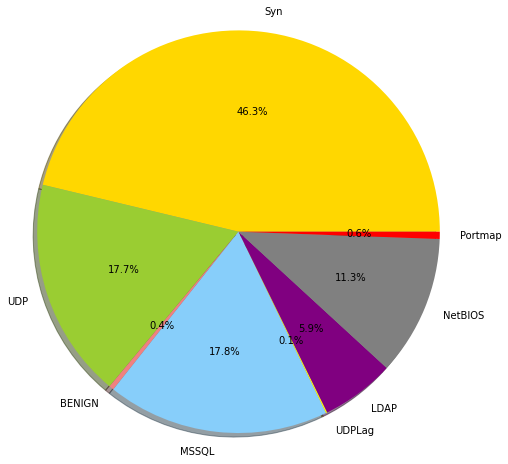

In [15]:
import matplotlib.pyplot as plt

labels = 'Syn','UDP','BENIGN','MSSQL','UDPLag','LDAP','NetBIOS','Portmap'
sizes = [len(df[df["Label"]==labels[0]]),len(df[df["Label"]==labels[1]]),len(df[df["Label"]==labels[2]]),
         len(df[df["Label"]==labels[3]]),len(df[df["Label"]==labels[4]]),len(df[df["Label"]==labels[5]]),
         len(df[df["Label"]==labels[6]]),len(df[df["Label"]==labels[7]])]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','yellow','purple','grey','red']
explode = (0, 0, 0,0,0,0,0,0) # explode 1st slice
print(sizes)
print(labels)
# Plot
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=360)
plt.axis('equal')
plt.show()

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.head())
    

                                  Flow ID   Source IP  Source Port  \
0    172.16.0.5-192.168.50.4-735-60874-17  172.16.0.5          735   
1      172.16.0.5-192.168.50.4-519-172-17  172.16.0.5          519   
2  172.16.0.5-192.168.50.4-48737-15358-17  172.16.0.5        48737   
3  172.16.0.5-192.168.50.4-61850-53628-17  172.16.0.5        61850   
4    172.16.0.5-192.168.50.4-744-55998-17  172.16.0.5          744   

  Destination IP  Destination Port  Protocol                   Timestamp  \
0   192.168.50.4             60874        17  2018-11-03 10:05:55.533415   
1   192.168.50.4               172        17  2018-11-03 10:27:59.221750   
2   192.168.50.4             15358        17  2018-11-03 11:01:32.374867   
3   192.168.50.4             53628        17  2018-11-03 10:41:35.744981   
4   192.168.50.4             55998        17  2018-11-03 10:02:12.666764   

   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              1                  2                       0

In [17]:
print(df['Label'].value_counts())

Syn        1801189
MSSQL       694593
UDP         688602
NetBIOS     438261
LDAP        230013
Portmap      22480
BENIGN       14958
UDPLag        3976
Name: Label, dtype: int64


In [18]:
df1 = df[df.isna().any(axis=1)]
df1.shape

(27, 87)

In [19]:
df.shape

(3894072, 87)

In [20]:
df=df.dropna()

In [21]:
df.shape

(3894045, 87)

In [22]:
k=df.dtypes
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(k)

Flow ID                         object
Source IP                       object
Source Port                      int64
Destination IP                  object
Destination Port                 int64
Protocol                         int64
Timestamp                       object
Flow Duration                    int64
Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets    float64
Total Length of Bwd Packets    float64
Fwd Packet Length Max          float64
Fwd Packet Length Min          float64
Fwd Packet Length Mean         float64
Fwd Packet Length Std          float64
Bwd Packet Length Max          float64
Bwd Packet Length Min          float64
Bwd Packet Length Mean         float64
Bwd Packet Length Std          float64
Flow Bytes/s                   float64
Flow Packets/s                 float64
Flow IAT Mean                  float64
Flow IAT Std                   float64
Flow IAT Max                   float64
Flow IAT Min             

In [23]:
print(df['SimillarHTTP'].dtypes)

object


#### Converting the SimilarHTTP column to string type as it is of type object

In [24]:
df['SimillarHTTP'] = df['SimillarHTTP'].astype('|S')

In [25]:
encoder1=preprocessing.LabelEncoder()
df['Flow ID']=encoder1.fit_transform(df['Flow ID'])
df['Source IP']=encoder1.fit_transform(df['Source IP'])
df['Destination IP']=encoder1.fit_transform(df['Destination IP'])
df['Timestamp']=encoder1.fit_transform(df['Timestamp'])
df['SimillarHTTP']=encoder1.fit_transform(df['SimillarHTTP'])
df['Label']=encoder1.fit_transform(df['Label'])

In [26]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,2535711,102,735,304,60874,17,260227,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,3
1,1486905,102,519,304,172,17,637370,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
2,1332852,102,48737,304,15358,17,1827338,106654,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,6
3,2129958,102,61850,304,53628,17,1271197,49,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2
4,2548684,102,744,304,55998,17,46146,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,3


In [27]:
count = np.isinf(df).values.sum()
count

396926

In [28]:
col_name = df.columns.to_series()[np.isinf(df).any()]
print(col_name)

Flow Bytes/s        Flow Bytes/s
Flow Packets/s    Flow Packets/s
dtype: object


In [29]:
print(df['Flow Bytes/s'].value_counts())

1.200000e+07    659587
4.580000e+08    261201
inf             198463
2.944000e+09    170937
8.020000e+08     69737
                 ...  
1.148087e+00         1
1.219178e+00         1
1.136842e+07         1
1.526512e+00         1
1.257952e+04         1
Name: Flow Bytes/s, Length: 199034, dtype: int64


In [30]:
print(df['Flow Packets/s'].value_counts())

2.000000e+06    1898111
1.000000e+06     225619
inf              198463
4.166667e+04     117175
4.081633e+04      95690
                 ...   
2.979368e+01          1
3.507681e-01          1
1.525107e+01          1
1.201880e+00          1
2.034270e-01          1
Name: Flow Packets/s, Length: 175505, dtype: int64


In [31]:
df['Flow Bytes/s']=df['Flow Bytes/s']/1000000 #for basic normalization we divided the data by 10^6
mm = df.loc[df['Flow Bytes/s'] != np.inf, 'Flow Bytes/s'].max()
mm=mm+200
df['Flow Bytes/s'].replace(np.inf,mm,inplace=True)
print(df['Flow Bytes/s'].value_counts())


1.200000e+01    659587
4.580000e+02    261201
3.144000e+03    198463
2.944000e+03    170937
8.020000e+02     69737
                 ...  
1.734579e-06         1
2.757282e+00         1
1.292287e-06         1
1.845178e-06         1
9.321774e-07         1
Name: Flow Bytes/s, Length: 199032, dtype: int64


In [32]:
df['Flow Packets/s']=df['Flow Packets/s']/1000000
m = df.loc[df['Flow Packets/s'] != np.inf, 'Flow Packets/s'].max()
m=m+200
df['Flow Packets/s'].replace(np.inf,m,inplace=True)
print(df['Flow Packets/s'].value_counts())

2.000000e+00    1898111
1.000000e+00     225619
2.040000e+02     198463
4.166667e-02     117175
4.081633e-02      95690
                 ...   
5.673759e-03          1
3.340000e-07          1
1.917285e-07          1
2.165298e-07          1
2.526832e-07          1
Name: Flow Packets/s, Length: 175502, dtype: int64


In [33]:
df.drop(columns=['Flow ID'], inplace=True)
df.drop(columns=['Timestamp'], inplace=True)
df.drop(columns=['Source IP'], inplace=True)
df.drop(columns=['Source Port'], inplace=True)
df.drop(columns=['Destination IP'], inplace=True)
df.drop(columns=['Destination Port'], inplace=True)
df

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,3
1,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
2,17,106654,4,0,1398.0,0.0,369.0,330.0,349.5,22.51666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,6
3,17,49,2,0,860.0,0.0,430.0,430.0,430.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2
4,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894067,6,1,2,0,12.0,0.0,6.0,6.0,6.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,5
3894068,6,1,2,0,12.0,0.0,6.0,6.0,6.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,5
3894069,6,105,2,2,12.0,12.0,6.0,6.0,6.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,5
3894070,6,1,2,0,12.0,0.0,6.0,6.0,6.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,5


In [34]:
X=df.iloc[:,0:84]
Y=df.iloc[:,-1]
X.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,3
1,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
2,17,106654,4,0,1398.0,0.0,369.0,330.0,349.5,22.51666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,6
3,17,49,2,0,860.0,0.0,430.0,430.0,430.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2
4,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,3


In [35]:
Y.value_counts()

5    1801173
2     694593
6     688602
3     438260
1     230013
4      22480
0      14948
7       3976
Name: Label, dtype: int64

In [36]:
Y.head()

0    3
1    1
2    6
3    2
4    3
Name: Label, dtype: int32

# Getting the Training and testing dataset

In [15]:
X_train, X_test, Y_train, Y_test=getTrainingAndTestingDataset()
X_train.shape

Read csv with chunks:  0.02303600311279297 sec


<ipython-input-5-b867784c8db2>:2: DtypeWarning: Columns (84) have mixed types.Specify dtype option on import or set low_memory=False.
  df=reads("C:/Users/Hp/PycharmProjects/pythonProject/AllDataCrop.csv")


2.000000e+00    1898111
1.000000e+00     225619
2.040000e+02     198463
4.166667e-02     117175
4.081633e-02      95690
                 ...   
5.673759e-03          1
3.340000e-07          1
1.917285e-07          1
2.165298e-07          1
2.526832e-07          1
Name: Flow Packets/s, Length: 175502, dtype: int64
2.000000e+00    1898111
1.000000e+00     225619
2.040000e+02     198463
4.166667e-02     117175
4.081633e-02      95690
                 ...   
5.673759e-03          1
3.340000e-07          1
1.917285e-07          1
2.165298e-07          1
2.526832e-07          1
Name: Flow Packets/s, Length: 175502, dtype: int64
2.000000e+00    1328310
1.000000e+00     157993
2.040000e+02     139111
4.166667e-02      81990
4.081633e-02      67001
                 ...   
2.522798e-07          1
1.584375e-06          1
1.263799e-05          1
3.323199e-07          1
2.526832e-07          1
Name: Flow Packets/s, Length: 145642, dtype: int64


(2725831, 80)

In [16]:
Y_test.value_counts()

5    540938
2    207667
6    206653
3    131564
1     68914
4      6777
0      4517
7      1184
Name: Label, dtype: int64

In [15]:
Y_train.value_counts()

5    1260235
2     486926
6     481949
3     306696
1     161099
4      15703
0      10431
7       2792
Name: Label, dtype: int64

In [16]:
X_test.shape

(1168214, 80)

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(X_train.head())
    

         Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
3085062         6             51                  2                       2   
2308859        17         216898                  6                       0   
2305917        17              1                  2                       0   
2833010         6            102                  2                       2   
214690          6              1                  2                       0   

         Total Length of Fwd Packets  Total Length of Bwd Packets  \
3085062                         12.0                         12.0   
2308859                       2088.0                          0.0   
2305917                       2944.0                          0.0   
2833010                         12.0                         12.0   
214690                          12.0                          0.0   

         Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
3085062                    6.

In [18]:
Y_train.shape

(2725831,)

In [19]:
Y_test=Y_test.iloc[0:]

In [20]:
models=['KNN',"GB",'RandomForestEntropy','RandomForestGini','NB']

# Making and saving all the models

In [58]:
decisiontree_entropy(X_train,Y_train)

saved


True

In [59]:
decisiontree_gini(X_train,Y_train)

saved


True

In [44]:
random_forest_entropy(X_train,Y_train)

saved


True

In [45]:
random_forest_gini(X_train,Y_train)

saved


True

In [46]:
Naive_Bayes(X_train,Y_train)

saved


True

In [47]:
KNearestNeighbor(X_train,Y_train,50,"C:/Users/Hp/PycharmProjects/pythonProject/KNN50.mdl")

saved


True

In [48]:
#checked for different learning rates but the maximum accuracy is in lr=0.5 so used here
GradientBoost(X_train,Y_train,0.5,"C:/Users/Hp/PycharmProjects/pythonProject/GradientBoost05.mdl")

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:14:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
saved


True

In [17]:
X_test=X_test.iloc[0:62803,:]
Y_test=Y_test[0:62803]#size decreased because of knn takes alot of time to predict

In [22]:
Y_test.value_counts()

5    29045
2    11172
6    11130
3     7043
1     3764
4      358
0      239
7       52
Name: Label, dtype: int64

# KNN

In [23]:
clf_KNN = load("C:/Users/Hp/PycharmProjects/pythonProject/KNN50.mdl")

In [52]:
type(X_test)

pandas.core.frame.DataFrame

In [82]:
y_pred_KNN=[]

In [83]:
total_time=0.0000
for x in range (1710604):
    start = time.time()
    yy= clf_KNN.predict([X_test.iloc[x,:]])
    y_pred_KNN.append(yy[0])
    end = time.time()
    print("Predicted in ", (end - start), "sec","  ",yy[0])
    total_time=total_time+(end - start)
    print(x,"  ",total_time)
print("Total Time",total_time)    

Predicted in  1.0584113597869873 sec    5
0    1.0584113597869873
Predicted in  0.9140291213989258 sec    5
1    1.972440481185913
Predicted in  0.8895580768585205 sec    2
2    2.8619985580444336
Predicted in  0.8904674053192139 sec    2
3    3.7524659633636475
Predicted in  0.8844692707061768 sec    2
4    4.636935234069824
Predicted in  0.8791472911834717 sec    1
5    5.516082525253296
Predicted in  0.8718795776367188 sec    5
6    6.387962102890015
Predicted in  0.8984758853912354 sec    5
7    7.28643798828125
Predicted in  0.908198356628418 sec    5
8    8.194636344909668
Predicted in  0.8950743675231934 sec    5
9    9.089710712432861
Predicted in  0.9100093841552734 sec    6
10    9.999720096588135
Predicted in  0.8939697742462158 sec    6
11    10.89368987083435
Predicted in  0.885998010635376 sec    2
12    11.779687881469727
Predicted in  0.9279673099517822 sec    5
13    12.707655191421509
Predicted in  0.8670651912689209 sec    3
14    13.57472038269043
Predicted in  0.87

KeyboardInterrupt: 

In [ ]:
with open("C:/Users/Hp/PycharmProjects/pythonProject/knn_predicted.txt", "wb") as fp:   #Pickling
    pickle.dump(y_pred_KNN, fp)

In [217]:
import pickle
with open("C:/Users/Hp/PycharmProjects/pythonProject/knn_predicted.txt", "rb") as fp:   # Unpickling
     y_pred_KNN = pickle.load(fp)
y_pred_KNN 

[5,
 5,
 2,
 2,
 2,
 1,
 5,
 5,
 5,
 5,
 6,
 6,
 2,
 5,
 3,
 2,
 5,
 5,
 2,
 3,
 1,
 5,
 5,
 2,
 5,
 5,
 5,
 5,
 2,
 1,
 5,
 5,
 2,
 1,
 3,
 5,
 5,
 5,
 6,
 5,
 3,
 5,
 5,
 3,
 5,
 6,
 1,
 6,
 5,
 6,
 5,
 5,
 5,
 6,
 5,
 5,
 3,
 1,
 5,
 5,
 5,
 2,
 6,
 5,
 5,
 2,
 5,
 1,
 2,
 5,
 6,
 5,
 5,
 2,
 5,
 6,
 5,
 6,
 3,
 5,
 5,
 5,
 5,
 6,
 5,
 5,
 3,
 3,
 5,
 6,
 6,
 5,
 3,
 5,
 2,
 2,
 3,
 5,
 3,
 2,
 2,
 5,
 6,
 5,
 2,
 5,
 3,
 3,
 2,
 3,
 5,
 5,
 1,
 6,
 2,
 5,
 5,
 5,
 6,
 3,
 5,
 3,
 5,
 2,
 3,
 3,
 5,
 6,
 5,
 2,
 5,
 3,
 5,
 3,
 5,
 3,
 5,
 2,
 3,
 2,
 6,
 5,
 2,
 6,
 5,
 5,
 5,
 3,
 2,
 6,
 6,
 2,
 5,
 1,
 6,
 5,
 5,
 6,
 2,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 1,
 5,
 2,
 5,
 5,
 5,
 3,
 5,
 6,
 2,
 2,
 5,
 2,
 5,
 5,
 1,
 5,
 5,
 1,
 6,
 2,
 5,
 2,
 2,
 6,
 5,
 5,
 5,
 5,
 2,
 6,
 3,
 5,
 3,
 6,
 5,
 5,
 2,
 5,
 3,
 2,
 3,
 5,
 1,
 5,
 6,
 3,
 5,
 5,
 6,
 5,
 5,
 6,
 6,
 5,
 5,
 5,
 5,
 6,
 5,
 6,
 2,
 5,
 5,
 6,
 3,
 5,
 5,
 5,
 3,
 3,
 5,
 6,
 5,
 2,
 5,
 5,
 5,
 2,
 2,
 5,
 2,


In [218]:
KNN_cre=creteria(Y_test,y_pred_KNN)
KNN_cre

{'Accuracy': 0.9177746286005446,
 'Precision': 0.8133442307377308,
 'Recall': 0.8877426160625511,
 'F1 score': 0.83825558967176,
 'Confusion Metrics': array([[  220,     0,     0,     0,     0,     1,     0,    18],
        [    0,  3453,     9,     0,     0,     0,   302,     0],
        [    0,    28, 10219,     1,     0,   909,    15,     0],
        [    0,     0,     0,  6482,   557,     3,     1,     0],
        [    0,     0,     1,   104,   253,     0,     0,     0],
        [    0,     0,  2274,     0,     0, 26771,     0,     0],
        [    0,   902,    26,     1,     0,     4, 10195,     2],
        [    6,     0,     0,     0,     0,     0,     0,    46]],
       dtype=int64)}

In [70]:
KNN_cre['Confusion Metrics']

array([[  238,     0,     0,     0,     0,     1,     0,     0],
       [    0,  3753,     9,     0,     0,     0,     2,     0],
       [    0,    30, 11126,     1,     0,     2,    13,     0],
       [    0,     0,     1,  7039,     0,     2,     1,     0],
       [    0,     0,     1,    71,   286,     0,     0,     0],
       [    0,     0,     0,     0,     0, 29045,     0,     0],
       [    0,     0,    26,     1,     0,     4, 11097,     2],
       [    0,     0,     0,     0,     0,     0,     0,    52]],
      dtype=int64)

# Gradient Boost

In [71]:
clf_gd = load("C:/Users/Hp/PycharmProjects/pythonProject/GradientBoost05.mdl")

In [72]:
y_pred_gd= clf_gd.predict(X_test)
y_pred_gd

array([5, 5, 2, ..., 2, 5, 6])

In [73]:
gd_cre=creteria(Y_test,y_pred_gd)
gd_cre

{'Accuracy': 0.9884241198668854,
 'Precision': 0.8267339856119322,
 'Recall': 0.8490853670198303,
 'F1 score': 0.8373094927900927,
 'Confusion Metrics': array([[  239,     0,     0,     0,     0,     0,     0,     0],
        [    0,  3750,    13,     1,     0,     0,     0,     0],
        [    0,   138, 10991,     0,     0,     0,    43,     0],
        [    0,     0,     0,  7041,     1,     0,     1,     0],
        [    0,     0,     1,   354,     0,     2,     1,     0],
        [    0,     0,     0,     0,     0, 29034,     3,     8],
        [    0,     0,   142,     1,     0,     0, 10978,     9],
        [    0,     0,     0,     0,     0,     1,     8,    43]],
       dtype=int64)}

In [74]:
gd_cre['Confusion Metrics']

array([[  239,     0,     0,     0,     0,     0,     0,     0],
       [    0,  3750,    13,     1,     0,     0,     0,     0],
       [    0,   138, 10991,     0,     0,     0,    43,     0],
       [    0,     0,     0,  7041,     1,     0,     1,     0],
       [    0,     0,     1,   354,     0,     2,     1,     0],
       [    0,     0,     0,     0,     0, 29034,     3,     8],
       [    0,     0,   142,     1,     0,     0, 10978,     9],
       [    0,     0,     0,     0,     0,     1,     8,    43]],
      dtype=int64)

In [75]:
importance_gd = clf_gd.feature_importances_
dictt=dict(zip(columns, importance_gd))
importance_gd={k: v for k, v in sorted(dictt.items(), key=lambda item: item[1],reverse=True)}
print ("{:<40} {:<10} ".format('Feature', 'Importance'))  
# print each data item.
for key, value in importance_gd.items():
    print ("{:<40} {:<10} ".format(key, value))      

Feature                                  Importance 
ACK Flag Count                           0.8490367531776428 
Fwd Packet Length Std                    0.07568186521530151 
Min Packet Length                        0.025686411187052727 
Fwd Packet Length Max                    0.012024401687085629 
Average Packet Size                      0.009461821056902409 
Fwd Packet Length Min                    0.008905714377760887 
Fwd Packet Length Mean                   0.007664439734071493 
Max Packet Length                        0.007374416571110487 
URG Flag Count                           0.0011450940510258079 
Inbound                                  0.0009124670177698135 
Init_Win_bytes_forward                   0.0005865833954885602 
Total Fwd Packets                        0.00030265495297499 
Total Length of Fwd Packets              0.00023466389393433928 
Packet Length Mean                       0.00019598338985815644 
min_seg_size_forward                     0.0001050751307047903

# Decision Tree With Gini

In [76]:
decision_gini = load("C:/Users/Hp/PycharmProjects/pythonProject/decisiontree_gini.mdl")

In [77]:
importance_decision_gini = decision_gini .feature_importances_
dictt=dict(zip(columns, importance_decision_gini))
importance_decision_gini={k: v for k, v in sorted(dictt.items(), key=lambda item: item[1],reverse=True)}
print ("{:<40} {:<10} ".format('Feature', 'Importance'))  
# print each data item.
for key, value in importance_decision_gini.items():
    print ("{:<40} {:<10} ".format(key, value))      

Feature                                  Importance 
ACK Flag Count                           0.4601559073777657 
Average Packet Size                      0.20715925332628973 
Fwd Packet Length Max                    0.19211514839534263 
Max Packet Length                        0.11650024082875801 
Min Packet Length                        0.008901870212226257 
Inbound                                  0.0031265227968344887 
Fwd Packet Length Mean                   0.0022784878376733014 
Flow Bytes/s                             0.0015899952629221258 
min_seg_size_forward                     0.0014492606389429593 
Total Length of Fwd Packets              0.0012729817128562264 
Fwd Packet Length Min                    0.0009164165072383531 
Fwd Header Length                        0.0007836354706048853 
Packet Length Mean                       0.0005776801781685499 
Fwd Header Length.1                      0.0004978169048885016 
Subflow Fwd Bytes                        0.000402390830360971

In [78]:
y_pred_decisiongini = decision_gini.predict(X_test)
y_pred_decisiongini

array([5, 5, 2, ..., 2, 5, 6])

In [79]:
decisiongini_cre=creteria(Y_test,y_pred_decisiongini)
decisiongini_cre

{'Accuracy': 0.9881215865484133,
 'Precision': 0.8712430773074764,
 'Recall': 0.8486703513462371,
 'F1 score': 0.8392415853460713,
 'Confusion Metrics': array([[  238,     0,     0,     0,     0,     1,     0,     0],
        [    0,  3749,    15,     0,     0,     0,     0,     0],
        [    0,   139, 10974,     1,     0,     1,    57,     0],
        [    0,     0,     0,  7040,     2,     0,     1,     0],
        [    0,     0,     2,   354,     1,     1,     0,     0],
        [    0,     0,     0,     0,     0, 29034,     3,     8],
        [    0,     0,   143,     2,     0,     0, 10978,     7],
        [    0,     0,     0,     0,     0,     1,     8,    43]],
       dtype=int64)}

In [80]:
decisiongini_cre['Confusion Metrics']

array([[  238,     0,     0,     0,     0,     1,     0,     0],
       [    0,  3749,    15,     0,     0,     0,     0,     0],
       [    0,   139, 10974,     1,     0,     1,    57,     0],
       [    0,     0,     0,  7040,     2,     0,     1,     0],
       [    0,     0,     2,   354,     1,     1,     0,     0],
       [    0,     0,     0,     0,     0, 29034,     3,     8],
       [    0,     0,   143,     2,     0,     0, 10978,     7],
       [    0,     0,     0,     0,     0,     1,     8,    43]],
      dtype=int64)

# Decision Tree With Entropy

In [81]:
decision_entropy = load("C:/Users/Hp/PycharmProjects/pythonProject/decisiontree_entropy.mdl")

In [82]:
importance_decision_entropy = decision_entropy .feature_importances_
dictt=dict(zip(columns, importance_decision_entropy))
importance_decision_entropy={k: v for k, v in sorted(dictt.items(), key=lambda item: item[1],reverse=True)}
print ("{:<40} {:<10} ".format('Feature', 'Importance'))  
# print each data item.
for key, value in importance_decision_entropy.items():
    print ("{:<40} {:<10} ".format(key, value))    

Feature                                  Importance 
Min Packet Length                        0.49640934178656027 
Average Packet Size                      0.24683216474284056 
Max Packet Length                        0.22378687853379026 
ACK Flag Count                           0.011530837511773704 
Init_Win_bytes_forward                   0.004629425168503786 
Flow Bytes/s                             0.004545919323931296 
min_seg_size_forward                     0.0017105906547327317 
Total Length of Fwd Packets              0.0014545624668625171 
Inbound                                  0.0014195048235718856 
Fwd IAT Min                              0.0009258695594770828 
Avg Fwd Segment Size                     0.0008873818205409081 
Fwd Header Length.1                      0.0008793732760365883 
Fwd Header Length                        0.0008312454151216615 
Fwd Packet Length Max                    0.0006344423431374986 
Packet Length Mean                       0.00062960585642614

In [83]:
#predicting
y_pred_decisionentropy = decision_entropy.predict(X_test)
y_pred_decisionentropy

array([5, 5, 2, ..., 2, 5, 6])

In [163]:
print(metrics.classification_report(Y_test,y_pred_decisionentropy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       0.96      1.00      0.98      3764
           2       0.99      0.98      0.98     11172
           3       0.95      1.00      0.98      7043
           4       0.33      0.00      0.01       358
           5       1.00      1.00      1.00     29045
           6       0.99      0.99      0.99     11130
           7       0.74      0.83      0.78        52

    accuracy                           0.99     62803
   macro avg       0.87      0.85      0.84     62803
weighted avg       0.98      0.99      0.99     62803



In [84]:
decisionentropy_cre=creteria(Y_test,y_pred_decisionentropy )
decisionentropy_cre

{'Accuracy': 0.9881056637421779,
 'Precision': 0.8712130291705127,
 'Recall': 0.8491928805279199,
 'F1 score': 0.8394872169761979,
 'Confusion Metrics': array([[  239,     0,     0,     0,     0,     0,     0,     0],
        [    0,  3750,    13,     1,     0,     0,     0,     0],
        [    0,   140, 10974,     0,     0,     1,    57,     0],
        [    0,     0,     0,  7040,     2,     0,     1,     0],
        [    0,     0,     2,   354,     1,     1,     0,     0],
        [    0,     0,     0,     0,     0, 29034,     3,     8],
        [    0,     0,   145,     2,     0,     1, 10975,     7],
        [    0,     0,     0,     0,     0,     1,     8,    43]],
       dtype=int64)}

In [85]:
decisionentropy_cre['Confusion Metrics']

array([[  239,     0,     0,     0,     0,     0,     0,     0],
       [    0,  3750,    13,     1,     0,     0,     0,     0],
       [    0,   140, 10974,     0,     0,     1,    57,     0],
       [    0,     0,     0,  7040,     2,     0,     1,     0],
       [    0,     0,     2,   354,     1,     1,     0,     0],
       [    0,     0,     0,     0,     0, 29034,     3,     8],
       [    0,     0,   145,     2,     0,     1, 10975,     7],
       [    0,     0,     0,     0,     0,     1,     8,    43]],
      dtype=int64)

# Random Forest With Entropy

In [86]:
clf_entropy = load("C:/Users/Hp/PycharmProjects/pythonProject/random-forest-entropy.mdl")

In [87]:
importance_entropy = clf_entropy.feature_importances_
dictt=dict(zip(columns, importance_entropy))
importance_entropy={k: v for k, v in sorted(dictt.items(), key=lambda item: item[1],reverse=True)}
print ("{:<40} {:<10} ".format('Feature', 'Importance'))  
# print each data item.
for key, value in importance_entropy.items():
    print ("{:<40} {:<10} ".format(key, value))    

Feature                                  Importance 
Min Packet Length                        0.1516582390898866 
Avg Fwd Segment Size                     0.10319791081195219 
Average Packet Size                      0.10243897039431166 
Fwd Packet Length Min                    0.09237528551001967 
Fwd Packet Length Max                    0.08174898895884546 
Packet Length Mean                       0.07729604928884745 
Fwd Packet Length Mean                   0.07418742326418588 
Max Packet Length                        0.05945193694944073 
Subflow Fwd Bytes                        0.051239177161365404 
Total Length of Fwd Packets              0.04550593225797074 
Flow Bytes/s                             0.03635540247212011 
Protocol                                 0.020263168962096047 
ACK Flag Count                           0.018727358730789064 
Init_Win_bytes_forward                   0.015746603998996606 
Packet Length Std                        0.0072441169618582355 
Packet Lengt

In [88]:
#predicting
y_pred_entropy = clf_entropy.predict(X_test)
y_pred_entropy

array([5, 5, 2, ..., 2, 5, 6])

In [162]:
print(metrics.classification_report(Y_test,y_pred_entropy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       0.96      1.00      0.98      3764
           2       0.99      0.98      0.98     11172
           3       0.95      1.00      0.98      7043
           4       0.50      0.00      0.01       358
           5       1.00      1.00      1.00     29045
           6       0.99      0.99      0.99     11130
           7       0.74      0.83      0.78        52

    accuracy                           0.99     62803
   macro avg       0.89      0.85      0.84     62803
weighted avg       0.99      0.99      0.99     62803



In [89]:
entropy_cre=creteria(Y_test,y_pred_entropy)
entropy_cre

{'Accuracy': 0.9883285830294731,
 'Precision': 0.892207595281413,
 'Recall': 0.8494223546691698,
 'F1 score': 0.8396834852551232,
 'Confusion Metrics': array([[  239,     0,     0,     0,     0,     0,     0,     0],
        [    0,  3753,    11,     0,     0,     0,     0,     0],
        [    0,   139, 10979,     0,     0,     0,    54,     0],
        [    0,     0,     0,  7041,     1,     0,     1,     0],
        [    0,     0,     2,   354,     1,     1,     0,     0],
        [    0,     0,     0,     0,     0, 29034,     3,     8],
        [    0,     0,   141,     2,     0,     0, 10980,     7],
        [    0,     0,     0,     0,     0,     1,     8,    43]],
       dtype=int64)}

In [90]:
entropy_cre['Confusion Metrics']

array([[  239,     0,     0,     0,     0,     0,     0,     0],
       [    0,  3753,    11,     0,     0,     0,     0,     0],
       [    0,   139, 10979,     0,     0,     0,    54,     0],
       [    0,     0,     0,  7041,     1,     0,     1,     0],
       [    0,     0,     2,   354,     1,     1,     0,     0],
       [    0,     0,     0,     0,     0, 29034,     3,     8],
       [    0,     0,   141,     2,     0,     0, 10980,     7],
       [    0,     0,     0,     0,     0,     1,     8,    43]],
      dtype=int64)

# Random Forest With GINI INDEX

In [91]:
clf_gini = load("C:/Users/Hp/PycharmProjects/pythonProject/random-forest-gini.mdl")

In [92]:
importance_gini = clf_gini.feature_importances_
dictt=dict(zip(columns, importance_gini))
importance_gini={k: v for k, v in sorted(dictt.items(), key=lambda item: item[1],reverse=True)}
print ("{:<40} {:<10} ".format('Feature', 'Importance'))  
# print each data item.
for key, value in importance_gini.items():
    print ("{:<40} {:<10} ".format(key, value))

Feature                                  Importance 
Max Packet Length                        0.11129622920770219 
Packet Length Mean                       0.09949788110653787 
Fwd Packet Length Mean                   0.08978768361272463 
Fwd Packet Length Min                    0.082308915592799 
Fwd Packet Length Max                    0.07948099233888806 
Average Packet Size                      0.0714209534437103 
Min Packet Length                        0.06650453244657727 
ACK Flag Count                           0.06295935865501383 
Avg Fwd Segment Size                     0.058923114953712864 
Total Length of Fwd Packets              0.053642089216641695 
Subflow Fwd Bytes                        0.050678226447501584 
Init_Win_bytes_forward                   0.04385040786410594 
Protocol                                 0.024315066262049524 
Flow Bytes/s                             0.01783189049094836 
Fwd Header Length.1                      0.009547008362278472 
Fwd Packet Leng

In [93]:
df_gini=pd.DataFrame(list(zip(columns, importance_gini)),
               columns =['Feature', 'Importance'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_gini)

                        Feature                   Importance
0                      Protocol            Max Packet Length
1                 Flow Duration           Packet Length Mean
2             Total Fwd Packets       Fwd Packet Length Mean
3        Total Backward Packets        Fwd Packet Length Min
4   Total Length of Fwd Packets        Fwd Packet Length Max
5   Total Length of Bwd Packets          Average Packet Size
6         Fwd Packet Length Max            Min Packet Length
7         Fwd Packet Length Min               ACK Flag Count
8        Fwd Packet Length Mean         Avg Fwd Segment Size
9         Fwd Packet Length Std  Total Length of Fwd Packets
10        Bwd Packet Length Max            Subflow Fwd Bytes
11        Bwd Packet Length Min       Init_Win_bytes_forward
12       Bwd Packet Length Mean                     Protocol
13        Bwd Packet Length Std                 Flow Bytes/s
14                 Flow Bytes/s          Fwd Header Length.1
15               Flow Pa

In [157]:
print(metrics.classification_report(Y_test,y_pred_gini))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       0.96      1.00      0.98      3764
           2       0.99      0.98      0.98     11172
           3       0.95      1.00      0.98      7043
           4       0.50      0.00      0.01       358
           5       1.00      1.00      1.00     29045
           6       0.99      0.99      0.99     11130
           7       0.73      0.83      0.77        52

    accuracy                           0.99     62803
   macro avg       0.89      0.85      0.84     62803
weighted avg       0.99      0.99      0.99     62803



In [94]:
#predicting
y_pred_gini= clf_gini.predict(X_test)
y_pred_gini

array([5, 5, 2, ..., 2, 5, 6])

In [223]:
gini_cre=creteria(Y_test,y_pred_gini)
gini_cre

{'Accuracy': 0.9882330461920609,
 'Precision': 0.8905902754728168,
 'Recall': 0.8493180240194801,
 'F1 score': 0.8387291082214895,
 'Confusion Metrics': array([[  239,     0,     0,     0,     0,     0,     0,     0],
        [    0,  3751,    13,     0,     0,     0,     0,     0],
        [    0,   139, 10977,     0,     0,     0,    56,     0],
        [    0,     0,     0,  7041,     1,     0,     1,     0],
        [    0,     0,     1,   354,     1,     2,     0,     0],
        [    0,     0,     0,     0,     0, 29033,     3,     9],
        [    0,     0,   143,     1,     0,     0, 10979,     7],
        [    0,     0,     0,     0,     0,     1,     8,    43]],
       dtype=int64)}

In [96]:
gini_cre['Precision']

0.8905902754728168

In [97]:
gini_cre['Recall']

0.8493180240194801

In [98]:
gini_cre['F1 score']

0.8387291082214895

In [99]:
gini_cre['Confusion Metrics']

array([[  239,     0,     0,     0,     0,     0,     0,     0],
       [    0,  3751,    13,     0,     0,     0,     0,     0],
       [    0,   139, 10977,     0,     0,     0,    56,     0],
       [    0,     0,     0,  7041,     1,     0,     1,     0],
       [    0,     0,     1,   354,     1,     2,     0,     0],
       [    0,     0,     0,     0,     0, 29033,     3,     9],
       [    0,     0,   143,     1,     0,     0, 10979,     7],
       [    0,     0,     0,     0,     0,     1,     8,    43]],
      dtype=int64)

# NAIVE BAYES


In [100]:
clf_NB = load("C:/Users/Hp/PycharmProjects/pythonProject/Naive_Bayes.mdl")

In [101]:
#predicting
y_pred_NB= clf_NB.predict(X_test)
y_pred_NB

array([5, 1, 1, ..., 4, 4, 1])

In [102]:
nb_cre=creteria(Y_test,y_pred_NB)
nb_cre

{'Accuracy': 0.18191806123911278,
 'Precision': 0.27589501511370085,
 'Recall': 0.22489092281632003,
 'F1 score': 0.14175348301321236,
 'Confusion Metrics': array([[   39,    29,     7,     1,   147,     7,     3,     6],
        [    0,  3086,     0,     0,   678,     0,     0,     0],
        [    1,  8478,     3,     1,  2682,     7,     0,     0],
        [    8,  4839,     0,     0,  2196,     0,     0,     0],
        [    0,   272,     0,     0,    86,     0,     0,     0],
        [  347, 10767,    17,   120, 14834,  2926,    13,    21],
        [    0,  3645,   190,     0,  2008,     0,  5285,     2],
        [    1,     0,     0,     0,    50,     1,     0,     0]],
       dtype=int64)}

In [103]:
nb_cre['Confusion Metrics']

array([[   39,    29,     7,     1,   147,     7,     3,     6],
       [    0,  3086,     0,     0,   678,     0,     0,     0],
       [    1,  8478,     3,     1,  2682,     7,     0,     0],
       [    8,  4839,     0,     0,  2196,     0,     0,     0],
       [    0,   272,     0,     0,    86,     0,     0,     0],
       [  347, 10767,    17,   120, 14834,  2926,    13,    21],
       [    0,  3645,   190,     0,  2008,     0,  5285,     2],
       [    1,     0,     0,     0,    50,     1,     0,     0]],
      dtype=int64)

In [224]:
data={'Decision Tree With Entropy':decisionentropy_cre,'Decision Tree With Gini':decisiongini_cre,'KNN':KNN_cre,'Gradient Boost':gd_cre,'Random Forest with Entropy':entropy_cre,'Random Forest with Gini':gini_cre,'Naive Bayes':nb_cre}
df_cre = pd.DataFrame.from_dict(data,orient='index')
df_cre


,Accuracy,Precision,Recall,F1 score,Confusion Metrics
Decision Tree With Entropy,0.988106,0.871213,0.849193,0.839487,"[[239, 0, 0, 0, 0, 0, 0, 0], [0, 3750, 13, 1, ..."
Decision Tree With Gini,0.988122,0.871243,0.848670,0.839242,"[[238, 0, 0, 0, 0, 1, 0, 0], [0, 3749, 15, 0, ..."
KNN,0.917775,0.813344,0.887743,0.838256,"[[220, 0, 0, 0, 0, 1, 0, 18], [0, 3453, 9, 0, ..."
Gradient Boost,0.988424,0.826734,0.849085,0.837309,"[[239, 0, 0, 0, 0, 0, 0, 0], [0, 3750, 13, 1, ..."
Random Forest with Entropy,0.988329,0.892208,0.849422,0.839683,"[[239, 0, 0, 0, 0, 0, 0, 0], [0, 3753, 11, 0, ..."
Random Forest with Gini,0.988233,0.890590,0.849318,0.838729,"[[239, 0, 0, 0, 0, 0, 0, 0], [0, 3751, 13, 0, ..."
Naive Bayes,0.181918,0.275895,0.224891,0.141753,"[[39, 29, 7, 1, 147, 7, 3, 6], [0, 3086, 0, 0,..."


In [225]:
df_cre.iloc[0,:]

Accuracy                                                      0.988106
Precision                                                     0.871213
Recall                                                        0.849193
F1 score                                                      0.839487
Confusion Metrics    [[239, 0, 0, 0, 0, 0, 0, 0], [0, 3750, 13, 1, ...
Name: Decision Tree With Entropy, dtype: object

In [226]:
for i in range(7):
    cmtx = pd.DataFrame(
    df_cre.iloc[i,4], 
    index=['true:0', 'true:1','true:2', 'true:3','true:4', 'true:5','true:6','true:7'], 
    columns=['pred:0', 'pred:1','pred:2', 'pred:3','pred:4', 'pred:5','pred:6','pred:7'])
    print("\033[1m" + df_cre.index[i]+ "\033[0m")
    print(cmtx,"\n\n")


Decision Tree With Entropy
        pred:0  pred:1  pred:2  pred:3  pred:4  pred:5  pred:6  pred:7
true:0     239       0       0       0       0       0       0       0
true:1       0    3750      13       1       0       0       0       0
true:2       0     140   10974       0       0       1      57       0
true:3       0       0       0    7040       2       0       1       0
true:4       0       0       2     354       1       1       0       0
true:5       0       0       0       0       0   29034       3       8
true:6       0       0     145       2       0       1   10975       7
true:7       0       0       0       0       0       1       8      43 


Decision Tree With Gini
        pred:0  pred:1  pred:2  pred:3  pred:4  pred:5  pred:6  pred:7
true:0     238       0       0       0       0       1       0       0
true:1       0    3749      15       0       0       0       0       0
true:2       0     139   10974       1       0       1      57       0
true:3       0       0 

In [227]:
df_plot=df_cre.iloc[:,0:4]
df_plot

,Accuracy,Precision,Recall,F1 score
Decision Tree With Entropy,0.988106,0.871213,0.849193,0.839487
Decision Tree With Gini,0.988122,0.871243,0.848670,0.839242
KNN,0.917775,0.813344,0.887743,0.838256
Gradient Boost,0.988424,0.826734,0.849085,0.837309
Random Forest with Entropy,0.988329,0.892208,0.849422,0.839683
Random Forest with Gini,0.988233,0.890590,0.849318,0.838729
Naive Bayes,0.181918,0.275895,0.224891,0.141753


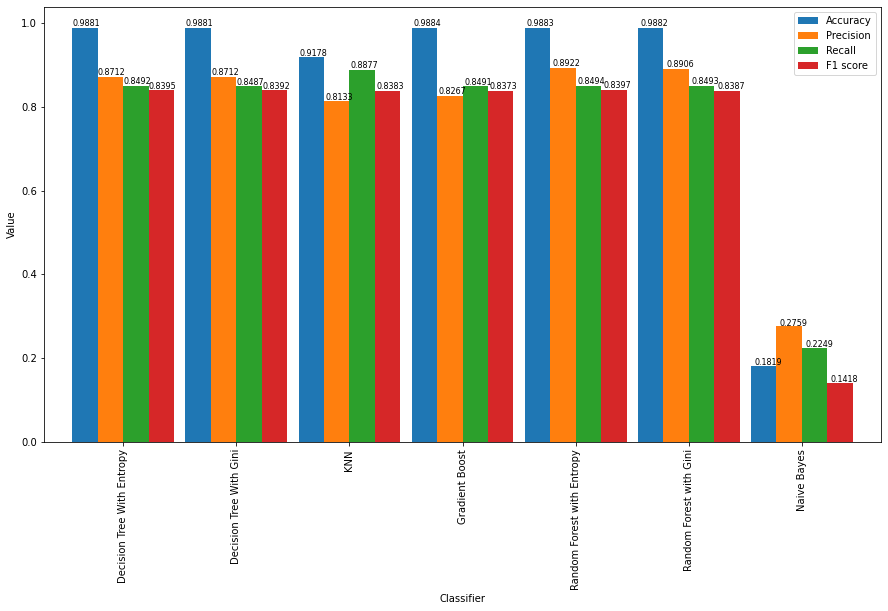

In [237]:
ax=df_plot.plot(kind='bar',xlabel ='Classifier',ylabel ='Value',figsize=(15, 8), width=0.9)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 4)), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=8)

In [187]:
print("\033[1m" +"Classifier                     Accuracy\n"+"\033[0m",df_plot.iloc[:,0])


Classifier                     Accuracy
 Decision Tree With Entropy    0.988106
Decision Tree With Gini       0.988122
KNN                           0.997341
Gradient Boost                0.988424
Random Forest with Entropy    0.988329
Random Forest with Gini       0.988233
Naive Bayes                   0.181918
Name: Accuracy, dtype: float64


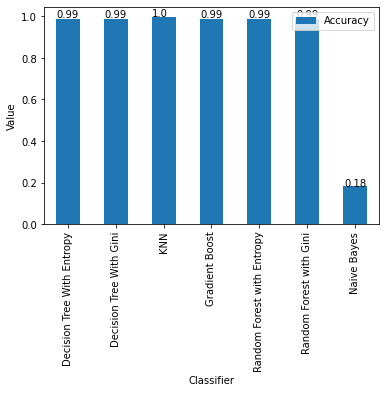

In [175]:
ax = df_plot.plot(kind='bar',y='Accuracy',xlabel ='Classifier',ylabel ='Value') 
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))

In [188]:
print("\033[1m" +"Classifier                     Precision\n"+"\033[0m",df_plot.iloc[:,1])

Classifier                     Precision
 Decision Tree With Entropy    0.871213
Decision Tree With Gini       0.871243
KNN                           0.992463
Gradient Boost                0.826734
Random Forest with Entropy    0.892208
Random Forest with Gini       0.890590
Naive Bayes                   0.275895
Name: Precision, dtype: float64


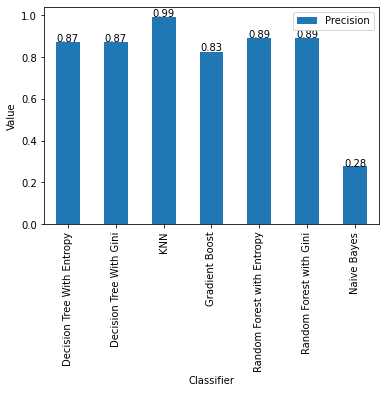

In [177]:
ax = df_plot.plot(kind='bar',y='Precision',xlabel ='Classifier',ylabel ='Value') 
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))



In [189]:
print("\033[1m" +"Classifier                     Recall\n"+"\033[0m",df_plot.iloc[:,2])

Classifier                     Recall
 Decision Tree With Entropy    0.849193
Decision Tree With Gini       0.848670
KNN                           0.973016
Gradient Boost                0.849085
Random Forest with Entropy    0.849422
Random Forest with Gini       0.849318
Naive Bayes                   0.224891
Name: Recall, dtype: float64


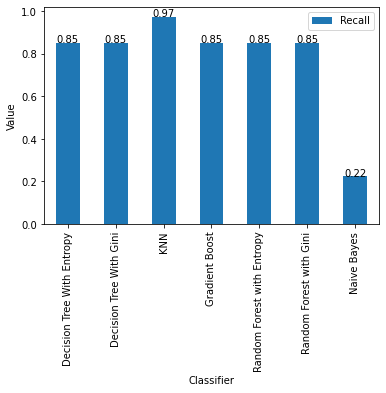

In [179]:
ax = df_plot.plot(kind='bar',y='Recall',xlabel ='Classifier',ylabel ='Value') 
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))


In [190]:
print("\033[1m" +"Classifier                     F1 Score\n"+"\033[0m",df_plot.iloc[:,3])

Classifier                     F1 Score
 Decision Tree With Entropy    0.839487
Decision Tree With Gini       0.839242
KNN                           0.981286
Gradient Boost                0.837309
Random Forest with Entropy    0.839683
Random Forest with Gini       0.838729
Naive Bayes                   0.141753
Name: F1 score, dtype: float64


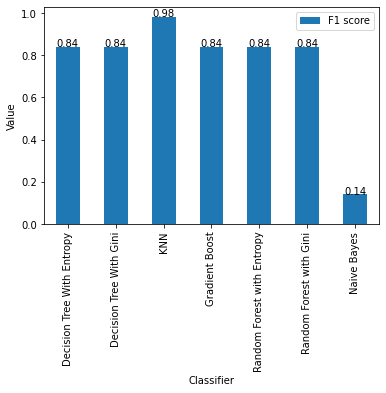

In [184]:
ax = df_plot.plot(kind='bar',y='F1 score',xlabel ='Classifier',ylabel ='Value') 
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))